### 5A: LSTM

In [12]:
# Import necessary packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Transformer

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

import tqdm
import kagglehub
from gensim.models import Word2Vec

In [13]:
# Hyperparameters config

class CFG:
  seed = 42

  n_epochs = 25
  batch_size = 32
  learning_rate = 0.001
  
  weight_decay = 1.0e-5
  patience = 2
  lr_factor = 0.5
  gradclip = 1.0
  # lrd_step = 5
  # lrd_gamma = 0.8
  lstm_dropout = 0.5
  lstm_dropout_embed = 0.5
  
  max_len = 20
  num_lstm_layers = 2
  # momentum = 0.9
  # nesterov = False

  vocab_size = None
  embedding_dim = 256
  hidden_dim = 256
  min_split_length = 15
  
  num_T_heads = 8
  T_embedding_dim = 512
  num_encoder_layers = 6
  num_decoder_layers = 6
  dim_feedforward = 2048
  T_dropout= 0.1

np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)

In [14]:
# Load and preprocess the dataset

path = kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp")
print("Dataset downloaded to:", path)

train_file = os.path.join(path, "train.txt")
val_file = os.path.join(path, "val.txt")
test_file = os.path.join(path, "test.txt")

def load_text(filepath):
    df = pd.read_csv(filepath, names=['text', 'emotion'], sep=';', usecols=['text'])
    return df['text'].tolist()

def preprocess(sentence):
    sentence = sentence.lower()
    tokens = sentence.split()
    return tokens

raw_train_sents = load_text(train_file)
raw_val_sents = load_text(val_file)
raw_test_sents = load_text(test_file)

train_tokens = [preprocess(s) for s in raw_train_sents]
val_tokens = [preprocess(s) for s in raw_val_sents]
test_tokens = [preprocess(s) for s in raw_test_sents]

print(train_tokens[:3])

Dataset downloaded to: C:\Users\Asus\.cache\kagglehub\datasets\praveengovi\emotions-dataset-for-nlp\versions\1
[['i', 'didnt', 'feel', 'humiliated'], ['i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake'], ['im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong']]


In [15]:
# Build vocabulary, map to indices, and construct Word2Vec embedding matrix

vocab_set = set()
for toks in train_tokens:
    vocab_set.update(toks)
vocab_list = ["EOL", "UNK"] + sorted(list(vocab_set))
vocab_size = len(vocab_list)
print("Vocabulary size:", vocab_size)
CFG.vocab_size = vocab_size

w2i = {w: i for i, w in enumerate(vocab_list)}
i2w = {i: w for i, w in enumerate(vocab_list)}

def word2idx(w):
    return w2i.get(w, 1)

def idx2word(i):
    return i2w.get(i, "UNK")

w2v_model = Word2Vec(sentences=train_tokens, vector_size=CFG.embedding_dim, 
                     window=5, min_count=1, seed=CFG.seed, epochs=CFG.n_epochs)
embedding_matrix = np.zeros((vocab_size, CFG.embedding_dim), dtype=np.float32)
for word, i in sorted(list(w2i.items())):
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.random.rand(CFG.embedding_dim).astype(np.float32)

Vocabulary size: 15214


In [16]:
# Expand the dataset to include more partial sentences, and set all sentences to max length

def expand_dataset(data):
    new_data = []
    for i in data:
        f = False
        while len(i) >= CFG.min_split_length:
            f = True
            x = i.copy()
            new_data.append(x)
            i.pop()
        if not f:
            new_data.append(i)

    return new_data

def pad(tokens):
    tokens = tokens[:CFG.max_len]
    while len(tokens) < CFG.max_len:
        tokens.append("EOL")
    return tokens

# train_tokens = expand_dataset(train_tokens)
# val_tokens = expand_dataset(val_tokens)
train_tokens = [pad(s) for s in train_tokens]
val_tokens = [pad(s) for s in val_tokens]
test_tokens = [pad(s) for s in test_tokens]


In [17]:
# Convert all tokens to indices

def convert_tokens_to_indices(list_of_token_lists):
    all_indices = []
    for tokens in list_of_token_lists:
        idx_seq = [word2idx(w) for w in tokens]
        all_indices.append(idx_seq)
    return np.array(all_indices, dtype=np.int64)

train_indices = convert_tokens_to_indices(train_tokens)
val_indices = convert_tokens_to_indices(val_tokens)
test_indices = convert_tokens_to_indices(test_tokens)

In [18]:
# Make the dataset as tensors

class NextWordDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        
        # Find first EOL token
        eol_idx = None
        for i, token in enumerate(sequence):
            if token == 0:  # EOL token
                eol_idx = i
                break
        
        if eol_idx is None:
            eol_idx = len(sequence)
        
        # Get meaningful part of sequence (before first EOL)
        meaningful_seq = sequence[:eol_idx]
        # Ensure sequence is at least 2 tokens long
        if len(meaningful_seq) < 2:
            meaningful_seq = np.pad(meaningful_seq, (0, 2 - len(meaningful_seq)),
                                    constant_values=0)  # Pad with EOL
        
        # Truncate or pad sequence to max_sequence_length
        if len(meaningful_seq) > CFG.max_len:
            meaningful_seq = meaningful_seq[:CFG.max_len]
        else:
            meaningful_seq = np.pad(meaningful_seq, 
                                    (0, CFG.max_len - len(meaningful_seq)),
                                    constant_values=0)  # Pad with EOL
        
        # Create input and target sequences
        input_seq = meaningful_seq[:-1]  # All tokens except last
        target_seq = meaningful_seq[1:]   # All tokens except first
        
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

In [19]:
# Define the LSTM model

class LSTMLanguageModel(nn.Module):
    def __init__(self, embedding_weights=None):
        super(LSTMLanguageModel, self).__init__()
        self.embedding = nn.Embedding(CFG.vocab_size, CFG.embedding_dim)
        if embedding_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_weights))        
        self.lstm = nn.LSTM(CFG.embedding_dim, CFG.hidden_dim, 
                            num_layers=CFG.num_lstm_layers, batch_first=True, dropout=CFG.lstm_dropout)
        
        self.layer_norm = nn.LayerNorm(CFG.hidden_dim)
        self.dropout = nn.Dropout(CFG.lstm_dropout)
        self.embed_dropout = nn.Dropout(CFG.lstm_dropout_embed)
        self.fc = nn.Linear(CFG.hidden_dim, CFG.vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x) 
        x = self.embed_dropout(x)
        
        # if hidden is None:
        #     batch_size = x.size(0)
        #     device = next(self.parameters()).device
        #     h = torch.zeros(CFG.num_lstm_layers, batch_size, CFG.hidden_dim).to(device)
        #     c = torch.zeros(CFG.num_lstm_layers, batch_size, CFG.hidden_dim).to(device)
        #     hidden = (h, c)
        
        x, hidden = self.lstm(x)#, hidden)
        x = self.dropout(x)
        x = self.layer_norm(x)
        logits = self.fc(x)
        return logits

In [20]:
# Prepare the dataloaders for training and testing

train_dataset = NextWordDataset(train_indices)
val_dataset = NextWordDataset(val_indices)
test_dataset = NextWordDataset(test_indices)

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMLanguageModel(embedding_weights=embedding_matrix)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # Ignore EOL
optimizer = optim.AdamW(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=CFG.patience, 
                                                       factor=CFG.lr_factor, verbose=True)
# optimizer = optim.SGD(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay,
#                       momentum=CFG.momentum, nesterov=CFG.nesterov)
# scheduler = StepLR(optimizer, step_size=CFG.lrd_step, gamma=CFG.lrd_gamma)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
# Training loop

train_losses, val_losses = [], []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(CFG.n_epochs):
    # Training phase
    
    model.train()
    train_loss = 0.0
    loop = tqdm.tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{CFG.n_epochs}]", unit="batch")
    
    for idx, (batch_x, batch_y) in enumerate(loop):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_x)
        logits = logits.view(-1, CFG.vocab_size)
        batch_y = batch_y.view(-1)
        
        loss = criterion(logits, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CFG.gradclip)
        optimizer.step()
        
        train_loss += loss.item()
        avg_loss = train_loss / (idx + 1)
        loop.set_postfix({"Avg Loss": f"{avg_loss:.4f}"})
    
    avg_loss = train_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            logits = model(batch_x)
            logits = logits.view(-1, CFG.vocab_size)
            batch_y = batch_y.view(-1)
            
            loss = criterion(logits, batch_y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{CFG.n_epochs}] || Avg Train Loss: {avg_loss:.6f} || Avg Val Loss: {avg_val_loss:.6f} || Current LR: {optimizer.param_groups[0]['lr']}")
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            # 'preprocessor_word2idx': preprocessor.word2idx,
            # 'preprocessor_idx2word': preprocessor.idx2word,
            'train_loss': avg_loss,
            'val_loss': avg_val_loss,
        }, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= CFG.patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
  

Epoch [1/25]: 100%|██████████| 500/500 [00:35<00:00, 14.13batch/s, Avg Loss=5.8800]


Epoch [1/25] || Avg Train Loss: 5.879990 || Avg Val Loss: 5.774945 || Current LR: 0.001


Epoch [2/25]: 100%|██████████| 500/500 [00:35<00:00, 14.19batch/s, Avg Loss=5.2933]


Epoch [2/25] || Avg Train Loss: 5.293280 || Avg Val Loss: 5.675813 || Current LR: 0.001


Epoch [3/25]: 100%|██████████| 500/500 [00:39<00:00, 12.64batch/s, Avg Loss=5.1030]


Epoch [3/25] || Avg Train Loss: 5.103007 || Avg Val Loss: 5.580204 || Current LR: 0.001


Epoch [4/25]: 100%|██████████| 500/500 [00:45<00:00, 10.96batch/s, Avg Loss=4.9635]


Epoch [4/25] || Avg Train Loss: 4.963470 || Avg Val Loss: 5.552071 || Current LR: 0.001


Epoch [5/25]: 100%|██████████| 500/500 [00:56<00:00,  8.81batch/s, Avg Loss=4.8477]


Epoch [5/25] || Avg Train Loss: 4.847740 || Avg Val Loss: 5.590595 || Current LR: 0.001


Epoch [6/25]: 100%|██████████| 500/500 [00:44<00:00, 11.34batch/s, Avg Loss=4.7489]


Epoch [6/25] || Avg Train Loss: 4.748873 || Avg Val Loss: 5.587513 || Current LR: 0.001
Early stopping triggered after 6 epochs


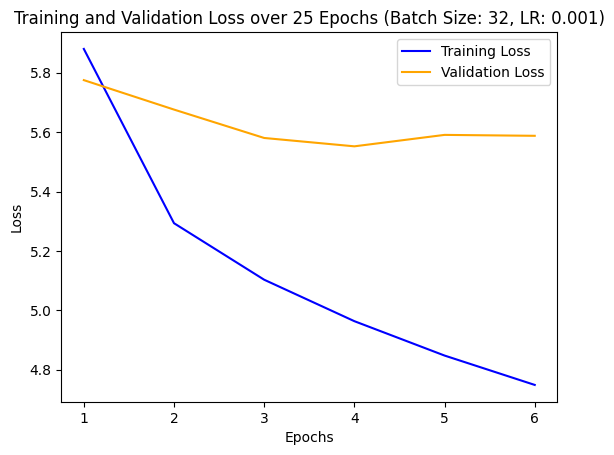

In [22]:
# Plot training loss
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", color="orange")
plt.title(f"Training and Validation Loss over {CFG.n_epochs} Epochs (Batch Size: {CFG.batch_size}, LR: {CFG.learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
# Testing loop

def test_model(model, loader):
    model.eval()
    total_tokens = 0
    correct_tokens = 0
    
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            logits = model(batch_x)
            preds = logits.argmax(dim=2)
            
            # Create a mask to ignore padding tokens
            mask = batch_y != 0
            
            # Apply the mask
            correct_tokens += ((preds == batch_y) & mask).sum().item()
            total_tokens += mask.sum().item()  # Only count non-padding tokens

    return correct_tokens / total_tokens


test_acc = test_model(model, test_loader)
print("Test Accuracy on Next-Word Prediction:", test_acc)

Test Accuracy on Next-Word Prediction: 0.20726548892759392


In [24]:
# Try partial sentence completion

def predict_completion(model, partial_sentence_tokens, max_length=CFG.max_len):
    """
    Given a partial sentence (as a list of tokens), generate the next words 
    up to max_length tokens total. This is a greedy approach.
    1) Start with partial input (padded to length 20).
    2) Pass it through the model, get the predicted next token at each step.
    3) Append the predicted token, repeat until we reach max_length or EOL.
    """
    model.eval()
    
    # Copy so we don't mutate the original
    tokens = partial_sentence_tokens[:]
    # If partial is longer than max_length, truncate
    tokens = tokens[:max_length]
    
    # If partial is shorter, pad with EOL
    while len(tokens) < max_length:
        tokens.append("EOL")
    
    # Convert to indices
    input_idxs = [word2idx(w) for w in tokens]
    x = torch.tensor([input_idxs], dtype=torch.long, device=device)  # shape (1, 20)
    
    # We'll do a simple approach: 
    # - get the model output for each position,
    # - pick the argmax from the final position (or from each new position),
    # - then fill it in for the next step. 
    # There are different ways to do "autoregressive" generation, but here's a naive method.
    
    generated = tokens[:]  # store the "in-progress" tokens
    for i in range(len(partial_sentence_tokens) - 1, max_length):
        with torch.no_grad():
            logits = model(x)         # shape: (1, 20, vocab_size)
            last_step = logits[0, i]  # shape: (vocab_size,)
            pred_idx = torch.argmax(last_step).item()
            pred_word = idx2word(pred_idx)
            
            # Replace the EOL or the token at position i+1 with the new predicted word
            if i+1 < max_length:
                generated[i+1] = pred_word
                # Update the input tensor
                x[0, i+1] = pred_idx
    
    # Now remove the original partial tokens from the front
    # or simply return the entire "generated" sequence from partial length onward
    return generated[len(partial_sentence_tokens):]

# EXAMPLE USAGE:
example_partial = ["i", "want"]
predicted_tokens = predict_completion(model, example_partial, CFG.max_len)
print("Partial Input:", example_partial)
print("Predicted Completion:", " ".join(predicted_tokens))

Partial Input: ['i', 'want']
Predicted Completion: to feel like i am being punished for the first time i have been able to be able


### 5B: Transformer

In [28]:
# Define model configuration

class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(CFG.vocab_size, CFG.T_embedding_dim)
        self.positional_encoding = PositionalEncoding(CFG.T_embedding_dim)
        self.transformer = Transformer(
            d_model=CFG.T_embedding_dim,
            nhead=CFG.num_T_heads,
            num_encoder_layers = CFG.num_encoder_layers,
            num_decoder_layers = CFG.num_decoder_layers,
            dim_feedforward = CFG.dim_feedforward,
            dropout = CFG.T_dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(CFG.T_embedding_dim, CFG.vocab_size)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        src = self.embedding(src) + self.positional_encoding(src)
        tgt = self.embedding(tgt) + self.positional_encoding(tgt)
        output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask, memory_mask=memory_mask)
        output = self.fc_out(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=CFG.T_dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, CFG.T_embedding_dim, 2) * -(torch.log(torch.tensor(10000.0)) / CFG.T_embedding_dim))
        pe = torch.zeros(max_len, CFG.T_embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x.unsqueeze(2) + self.pe[:x.size(1), :]
        return self.dropout(x)


modelT = TransformerModel()
modelT.to(device="cuda")
# print(modelT)

src = torch.randint(0, CFG.vocab_size, (32, 20))
tgt = torch.randint(0, CFG.vocab_size, (32, 20))

src, tgt = src.to(device="cuda"), tgt.to(device="cuda")

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.AdamW(modelT.parameters(), lr=0.001)

output = modelT(src, tgt)

output = output.view(-1, CFG.vocab_size)
tgt = tgt.view(-1)
loss = criterion(output, tgt)

loss.backward()
optimizer.step()

print(f"Training Loss: {loss.item()}")


Training Loss: 9.794084548950195


In [29]:
# Try partial sentence completion

def predict_completionT(model, partial_sentence_tokens, max_length=CFG.max_len):
    """
    Given a partial sentence (as a list of tokens), generate the next words 
    up to max_length tokens total. This is a greedy approach.
    1) Start with partial input (padded to length 20).
    2) Pass it through the model, get the predicted next token at each step.
    3) Append the predicted token, repeat until we reach max_length or EOL.
    """
    model.eval()
    
    # Copy so we don't mutate the original
    tokens = partial_sentence_tokens[:]
    # If partial is longer than max_length, truncate
    tokens = tokens[:max_length]
    
    # If partial is shorter, pad with EOL
    while len(tokens) < max_length:
        tokens.append("EOL")
    
    # Convert to indices
    input_idxs = [word2idx(w) for w in tokens]
    x = torch.tensor([input_idxs], dtype=torch.long, device=device)  # shape (1, 20)
    
    # We'll do a simple approach: 
    # - get the model output for each position,
    # - pick the argmax from the final position (or from each new position),
    # - then fill it in for the next step. 
    # There are different ways to do "autoregressive" generation, but here's a naive method.
    
    generated = tokens[:]  # store the "in-progress" tokens
    for i in range(len(partial_sentence_tokens) - 1, max_length):
        with torch.no_grad():
            logits = model(x)         # shape: (1, 20, vocab_size)
            last_step = logits[0, i]  # shape: (vocab_size,)
            pred_idx = torch.argmax(last_step).item()
            pred_word = idx2word(pred_idx)
            
            # Replace the EOL or the token at position i+1 with the new predicted word
            if i+1 < max_length:
                generated[i+1] = pred_word
                # Update the input tensor
                x[0, i+1] = pred_idx
    
    # Now remove the original partial tokens from the front
    # or simply return the entire "generated" sequence from partial length onward
    return generated[len(partial_sentence_tokens):]

# EXAMPLE USAGE:
example_partial = ["i", "want"]
predicted_tokens = predict_completionT(modelT, example_partial, CFG.max_len)
print("Partial Input:", example_partial)
print("Predicted Completion:", " ".join(predicted_tokens))

TypeError: TransformerModel.forward() missing 1 required positional argument: 'tgt'